<a href="https://colab.research.google.com/github/IsuruBoyagane15/vue4logs-baseline/blob/master/vue4logs_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install tensorflow 1.0.1

In [1]:
!pip3 install tensorflow==1.0.1
import tensorflow as tf

     |████████████████████████████████| 44.5MB 84kB/s 
  Found existing installation: tensorflow 2.2.0
    Uninstalling tensorflow-2.2.0:
      Successfully uninstalled tensorflow-2.2.0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:455: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:456: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:457: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:458: FutureWarning: Passing (type, 1) or 

In [0]:
# import tensorflow_datasets as tfds
import os
import numpy as np
import nltk
import itertools
tf.set_random_seed(0)
np.random.seed(0)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
cd '/content/drive/My Drive/Vue4Logs/Thaler2017'

/content/drive/My Drive/Vue4Logs/Thaler2017


# configs

In [0]:
dataset = "zookeeper"
experiment_type = 'check'
MAXIMUM_LOG_LINES = -1

In [0]:
!mkdir /content/drive/My\ Drive/Vue4Logs/our_experiments/{experiment_type}/{dataset}
result_dir = '/content/drive/My Drive/Vue4Logs/our_experiments/' + experiment_type + '/' + dataset 

# read logs

In [0]:
log_lines = list(open("/content/drive/My Drive/Vue4Logs/Datasets_TB/final_training_log_files/" + dataset + "/" + dataset +".log", 'r'))

In [8]:
print(len(log_lines))

70393


In [9]:
print(log_lines[-1])

2015-07-29 19:33:17,781 - WARN  [RecvWorker:188978561024:QuorumCnxManager$RecvWorker@762] - Connection broken for id 188978561024, my id = 2, error = 



# specify files to write preprocessed data

In [0]:
processed_datafile = result_dir  + '/log.processed'
test_data_processed = result_dir + '/test_log.processed'

# tokenize logs

In [11]:
split_tokens = ['.', '"' , "'" , ',' , '(', ')', '!', '?', ';', ':', "\\" , '/', '[',']',"=","-",'_' ]
LOG_LINE_START_TOKEN = "LOG_START"
LOG_LINE_END_TOKEN = "LOG_END"
UNKNOWN_TOKEN = "UNKNOWN_TOKEN"
PAD_TOKEN = "PAD_TOKEN"
MAX_LINE_LENGTH = 200

tokenized_log_lines = []
total_lines = len(log_lines) if MAXIMUM_LOG_LINES==-1 else MAXIMUM_LOG_LINES

for i, log_line in enumerate(log_lines):
  log_line = log_line.lower()
  for char in split_tokens:
    log_line = log_line.replace(char, ' ' + char + ' ')
  tokenized_log_line = log_line.split(" ")[0:MAX_LINE_LENGTH]
  tokenized_log_line = [LOG_LINE_START_TOKEN] + tokenized_log_line + [LOG_LINE_END_TOKEN]
  tokenized_log_lines.append(tokenized_log_line)
  if MAXIMUM_LOG_LINES>0 and i>MAXIMUM_LOG_LINES:
    break
print ("Tokenized logfile.")

Tokenized logfile.


# create vocab

In [12]:
word_frequencies = nltk.FreqDist(itertools.chain(*tokenized_log_lines))
vocabulary_size = len(word_frequencies.items())
vocabulary = word_frequencies.most_common(vocabulary_size)
vocabulary = [("PAD_TOKEN", 0) ] + vocabulary
vocabulary_size+=1 # for pad token
vocabulary_size+=1 # for unk token

index_to_word = [word[0] for word in vocabulary]
index_to_word.append(UNKNOWN_TOKEN)
word_to_index = dict([(w,i) for i,w in enumerate(index_to_word)])
print("Created index_to_word and word_to_index dictionary. ")

for i, log_line in enumerate(tokenized_log_lines):
      tokenized_log_lines[i] = [w if w in word_to_index else UNKNOWN_TOKEN for w in log_line]

PAD_ID = word_to_index[PAD_TOKEN]
UNK_ID = word_to_index[UNKNOWN_TOKEN]
BOS_ID = word_to_index[LOG_LINE_START_TOKEN]
EOS_ID = word_to_index[LOG_LINE_END_TOKEN]

if not PAD_ID == 0:
  raise("Padding ID has to be 0, because tensorflow says so and all masking / padding algorithms depend on it")

print ("Tokenized loglines samples:")
for tl in tokenized_log_lines[0:5]:
    print("\t%s\n"%tl)
print ("Vocabulary size %d." % vocabulary_size)
print ("PAD_ID\t %d" % PAD_ID)
print ("UNK_ID\t %d" % UNK_ID)
print ("BOS_ID\t %d" % BOS_ID)
print ("EOS_ID\t %d" % EOS_ID)

Created index_to_word and word_to_index dictionary. 
Tokenized loglines samples:
	['LOG_START', '2015', '-', '07', '-', '30', '16', ':', '18', ':', '34', ',', '002', '', '-', '', 'info', '', '', '[', 'processthread', '(', 'sid', ':', '2', 'cport', ':', '', '-', '1', ')', '', ':', '', ':', 'preprequestprocessor@476', ']', '', '', '-', '', 'processed', 'session', 'termination', 'for', 'sessionid', ':', '', '0x24ed9311942009b\n', 'LOG_END']

	['LOG_START', '2015', '-', '07', '-', '29', '19', ':', '27', ':', '55', ',', '173', '', '-', '', 'warn', '', '', '[', 'sendworker', ':', '188978561024', ':', 'quorumcnxmanager$sendworker@679', ']', '', '', '-', '', 'interrupted', 'while', 'waiting', 'for', 'message', 'on', 'queue\n', 'LOG_END']

	['LOG_START', '2015', '-', '07', '-', '31', '11', ':', '00', ':', '54', ',', '037', '', '-', '', 'info', '', '', '[', 'nioservercxn', '.', 'factory', ':', '0', '.', '0', '.', '0', '.', '0', '/', '0', '.', '0', '.', '0', '.', '0', ':', '2181', ':', 'nioserver

# tekenize test 2000

In [13]:
tokenized_test_log_lines = []

test_log_lines = list(open("/content/drive/My Drive/Vue4Logs/Datasets_TB/ground_truth/" + dataset + "/" + dataset + ".log", 'r'))
# print("Loaded %i test_loglines"%len(test_loglines))
# total_lines = len(test_loglines) if g.vocabulary_max_lines==-1 else g.vocabulary_max_lines
# print("Tokenizing test %i lines... "%total_lines)
print("test_loglines",len(test_log_lines))

for i, test_log_line in enumerate(test_log_lines):
    test_log_line = test_log_line.lower()
    for char in split_tokens:
        test_log_line = test_log_line.replace(char, ' ' + char + ' ')
    
    tokenized_test_log_line = test_log_line.split(" ")[0:MAX_LINE_LENGTH]
    tokenized_test_log_line = [LOG_LINE_START_TOKEN] + tokenized_test_log_line + [LOG_LINE_END_TOKEN]
    tokenized_test_log_lines.append(tokenized_test_log_line)

    # if g.vocabulary_max_lines>0 and i>g.vocabulary_max_lines:
    #     break

for i, test_log_line in enumerate(tokenized_test_log_lines):
    tokenized_test_log_lines[i] = [w if w in word_to_index else UNKNOWN_TOKEN for w in test_log_line]

print ("Tokenized test logfile.")

test_loglines 2000
Tokenized test logfile.


# average length

In [14]:
line_lengths = []
for logline in tokenized_log_lines: 
    line_lengths.append(len(logline))
np.average(line_lengths)

47.99803957779893

# Process Training data

In [0]:
X_train = np.asarray([[word_to_index[w] for w in logline] for logline in tokenized_log_lines])
maximum_sequence_length =-1
train_numbers_file = open(processed_datafile,"w")
for i, logline_as_word_id_sequence in enumerate(X_train):
    reversed_seq = list(reversed(logline_as_word_id_sequence))
    # add sequence length to example

    sequence_length = str(len(logline_as_word_id_sequence))                             
    if len(logline_as_word_id_sequence)>maximum_sequence_length: 
      maximum_sequence_length=len(logline_as_word_id_sequence) # find maximum sequence length


    word_id_seq = ",".join(map(str,logline_as_word_id_sequence)) # encoder input: 1,2,3 
    word_id_seq_reversed = ",".join(map(str,reversed_seq)) # decoder input: 3,2,1 
    target_seq = ",".join(map(str, reversed_seq[1:]+[PAD_ID])) # decoder target: 2,1,PAD 

    signature_id =  5 # experiment_lib.extract_pattern_id(loglines[i]) -------- put bogus value---------------
    # assert not signature_id==0,"Each log line has to be associated to one signature, none for (%s). Check extract_pattern_id method."%loglines[i]
    # write      
    train_numbers_file.write("%s|%s|%s|%s|%s\n"%(signature_id, sequence_length, word_id_seq,word_id_seq_reversed,target_seq))

train_numbers_file.close()

array_to_xtrain = []

X_test = np.asarray([[word_to_index[w] for w in log_line] for log_line in tokenized_test_log_lines])
maximum_sequence_length =-1
test_numbers_file = open(test_data_processed,"w")
# one_percent = len(X_test)/100

for i, test_logline_as_word_id_sequence in enumerate(X_test):

    reversed_seq = list(reversed(test_logline_as_word_id_sequence))
    # add sequence length to example

    sequence_length = str(len(test_logline_as_word_id_sequence))
    if len(test_logline_as_word_id_sequence)>maximum_sequence_length: 
      maximum_sequence_length=len(test_logline_as_word_id_sequence) # find maximum sequence length


    word_id_seq = ",".join(map(str,test_logline_as_word_id_sequence)) # encoder input: 1,2,3 
    word_id_seq_reversed = ",".join(map(str,reversed_seq)) # decoder input: 3,2,1 
    target_seq = ",".join(map(str, reversed_seq[1:]+[PAD_ID])) # decoder target: 2,1,PAD 

    # signature_id = experiment_lib.extract_pattern_id(loglines[i]) #######
    signature_id = 5

    # assert not signature_id==0,"Each log line has to be associated to one signature, none for (%s). Check extract_pattern_id method."%loglines[i]
    # write      
    test_numbers_file.write("%s|%s|%s|%s|%s\n"%(signature_id, sequence_length, word_id_seq,word_id_seq_reversed,target_seq))
test_numbers_file.close()
##

# if not os.path.exists(labels_true_file):
#     os.system("python3 create_true_labels.py -en %s"%EXPERIMENT_ID)

In [16]:
word_id_seq

'10,11,3,36,3,9,69,2,30,2,19,6,219,1,3,1,23,1,1,7,135,75,105,2,68,136,2,1,3,32,76,1,2,1,2,140,8,1,1,3,1,137,62,141,22,92,2,1,9834,12'

In [17]:
word_id_seq_reversed

'12,9834,1,2,92,22,141,62,137,1,3,1,1,8,140,2,1,2,1,76,32,3,1,2,136,68,2,105,75,135,7,1,1,23,1,3,1,219,6,19,2,30,2,69,9,3,36,3,11,10'

In [18]:
target_seq

'9834,1,2,92,22,141,62,137,1,3,1,1,8,140,2,1,2,1,76,32,3,1,2,136,68,2,105,75,135,7,1,1,23,1,3,1,219,6,19,2,30,2,69,9,3,36,3,11,10,0'

#  Graph Hyper parameters

In [0]:
# TDB save vocabulary file
state_size = 256 # size of vector internal of a cell
batch_size = 200

num_examples_to_visualize = min(10000, len(tokenized_log_lines)) # how many dots to show
num_examples_to_embed = len(tokenized_test_log_lines) #len(tokenized_loglines) -------------changed according to the test set------------

dropout_keep_probability = 0.7
num_lstm_layers = 1

DTYPE=tf.float32
num_samples = min(vocabulary_size, 500) # number of samples to draw for sampled softmax
max_gradient_norm = 0.5 # to be defined

LEARNING_RATE = 0.02
learning_rate_decay_factor = 0.95
l1_scale= 0.000
epochs = 2

num_examples = len(X_train)
max_steps = int(epochs * (num_examples / batch_size))
learning_rate_adjustments = 10 # how many times to apply learning rate decay over all epochs
adjust_learning_rate_after_steps = max_steps / learning_rate_adjustments

# some tf varioables
tf_keep_probabiltiy = tf.constant(dropout_keep_probability) 
tf_global_step = tf.Variable(0, trainable=False)


# clustering hierarchy
examples_in_hierarchy = 50
color_threshhold = 0.2

# threshold for vmeasure, homogenity etc.
h_threshold = 0.004

# save hyperparameters
hyperparams = {
    "state_size":state_size,
    "num_examples_to_visualize":num_examples_to_visualize,
    "dropout_keep_probability":dropout_keep_probability,
    "num_lstm_layers":num_lstm_layers,
    "learning_rate_decay_factor":learning_rate_decay_factor,
    "batch_size":batch_size,
    "dtype":str(DTYPE),
    "num_samples":num_samples,
    "max_gradient_norm":max_gradient_norm,
    "learning_rate":LEARNING_RATE,
    "epochs":epochs,
    "num_examples":num_examples,
    "max_steps":max_steps,
    "examples_in_hierarchy":examples_in_hierarchy,
    "color_threshhold":color_threshhold,    
    "h_threshold":h_threshold,
}


# save_to_json(hyperparams, HYPERPARAMETERS_FILE)

#  Graph

## Learning Rate

In [0]:
learning_rate = tf.train.exponential_decay(
  learning_rate=LEARNING_RATE, 
  global_step=tf_global_step, # current learning step
  decay_steps= adjust_learning_rate_after_steps, # how many steps to train after decaying learning rate      
  decay_rate=learning_rate_decay_factor,                
  staircase=True)


## Input, Output and Target of the graph

In [0]:
# inputs, outputs
x_e = tf.placeholder(tf.int32, [batch_size, None]) # encoder inputs loglines [batch_size, num_steps]
x_d = tf.placeholder(tf.int32, [batch_size, None]) # decoder inputs 
y_d = tf.placeholder(tf.int32, [batch_size, None]) # reversed loglines [batch_size, num_steps]

visualization_embeddings = tf.Variable(np.zeros([num_examples_to_visualize, state_size]) , trainable=False, name="VisualizationEmbeddings", dtype= DTYPE   )

word_embeddings = tf.get_variable('word_embeddings', [vocabulary_size, state_size], dtype= DTYPE ) # each row is a dense vector for each word.

# Encoder Inputs
encoder_inputs = tf.nn.embedding_lookup(word_embeddings, x_e) # [batch_size, max_time, embedding_size]
encoder_sequence_lengths = tf.placeholder(tf.int32, [batch_size]) # [batch_size]

# Decoder Inputs
decoder_inputs = tf.nn.embedding_lookup(word_embeddings, x_d) # need to be defined  [batch_size, max_time, embedding_size]
decoder_sequence_lengths = tf.placeholder(tf.int32, [batch_size]) # [batch_size]

# Decoder Labels
decoder_labels = y_d # this are our target words

## LSTM, Dropout Wrapper, MultiRNNCell

In [0]:

from tensorflow.contrib.seq2seq.python.ops.seq2seq import dynamic_rnn_decoder
from tensorflow.contrib.seq2seq.python.ops.attention_decoder_fn import attention_decoder_fn_train,attention_decoder_fn_inference
from tensorflow.contrib.seq2seq.python.ops.decoder_fn import simple_decoder_fn_train
from tensorflow.contrib.seq2seq.python.ops.attention_decoder_fn import prepare_attention
from tensorflow.contrib import rnn as contrib_rnn

from library.core_rnn_cell_impl import DropoutWrapper as DtypeDropoutWrapper # import v1.1.0 dropout wrapper to support setting DTYPE to half-precision

# Define cells
with tf.variable_scope("encoder_scope") as encoder_scope:

    cell = contrib_rnn.LSTMCell(num_units=state_size, state_is_tuple=True)
    cell = DtypeDropoutWrapper(cell=cell, output_keep_prob=tf_keep_probabiltiy, dtype=DTYPE)
    cell = contrib_rnn.MultiRNNCell(cells=[cell] * num_lstm_layers, state_is_tuple=True)

    encoder_cell = cell # needs to be defined

    # encode inputs
    encoder_outputs, last_encoder_state = tf.nn.dynamic_rnn(
        cell=encoder_cell,
        dtype=DTYPE,
        sequence_length=encoder_sequence_lengths,
        inputs=encoder_inputs,
        )

## Dynamic RNN decoder

In [0]:
with tf.variable_scope("decoder_scope") as decoder_scope:
        # output projection
    # we need to specify output projection manually, because sampled softmax needs to have access to the the projection matrix 
    output_projection_w_t = tf.get_variable("output_projection_w", [vocabulary_size, state_size], dtype=DTYPE)
    output_projection_w = tf.transpose(output_projection_w_t)
    output_projection_b = tf.get_variable("output_projection_b", [vocabulary_size], dtype=DTYPE)
    
    # define decoder cell
    decoder_cell = tf.contrib.rnn.LSTMCell(num_units=state_size)
    decoder_cell = DtypeDropoutWrapper(cell=decoder_cell, output_keep_prob=tf_keep_probabiltiy, dtype=DTYPE)
    decoder_cell = contrib_rnn.MultiRNNCell(cells=[decoder_cell] * num_lstm_layers, state_is_tuple=True)   
    # decoder_cell = contrib_rnn.OutputProjectionWrapper(decoder_cell, output_size=vocabulary_size ) # rnn output: [batch_size, max_time, vocabulary_size ]

    # define decoder train netowrk
    decoder_outputs_tr, _ , _ = dynamic_rnn_decoder( # decoder outputs, final hidden state, final context state
        cell=decoder_cell, # the cell function
        decoder_fn= simple_decoder_fn_train(last_encoder_state, name=None),
        inputs=decoder_inputs, # [batch_size, max_time, embedding_size].
        sequence_length=decoder_sequence_lengths, #  length for sequence in the batch [batch_size] 
        parallel_iterations=None, # Tradeoff - time for memory
        swap_memory=False,
        time_major=False)
    
    # define decoder inference network
    decoder_scope.reuse_variables()    
    

# Objective and Optimization


## Loss function

In [24]:
print("Decoder Output  Shape: [batch_size=%s, max_timesteps=%s, vocabulary_size=%s]"%tuple(decoder_outputs_tr.shape))
#from library.nn_impl import sampled_softmax_loss as dtype_sampled_softmax_loss # imported cutom loss function to support dtype  as a parameter => half precision

# reshape outputs of decoders to [ batch_size * max_time , vocabulary_size ]
decoder_forward_outputs = tf.reshape(decoder_outputs_tr,[-1, state_size])
decoder_target_labels  = tf.reshape(decoder_labels ,[-1, 1])# =>  [ batch_size * max_time ]  sequence of correc tlabel

sampled_softmax_losses = tf.nn.sampled_softmax_loss(
    weights = output_projection_w_t,# [num_classes, state_size]
    biases = output_projection_b, # [num_classes]
    inputs = decoder_forward_outputs, #  inputs: A `Tensor` of shape `[batch_size, state_size]`.  The forward activations of the input network. 
    labels = decoder_target_labels , 
    num_sampled = num_samples,
    num_classes=vocabulary_size,
    num_true = 1,
)    
total_loss_op = tf.reduce_mean(sampled_softmax_losses) 


Decoder Output  Shape: [batch_size=200, max_timesteps=?, vocabulary_size=256]


## Regularization

In [25]:
l1_regularizer = tf.contrib.layers.l1_regularizer(
    scale=l1_scale, scope=None
)
weights = tf.trainable_variables()
regularization_penalty = tf.contrib.layers.apply_regularization(l1_regularizer, [word_embeddings])

regularized_loss = total_loss_op + regularization_penalty

INFO:tensorflow:Scale of 0 disables regularizer.


## Trainings step

In [0]:
# get gradients for all trainable parameters with respect to our loss funciton
params = tf.trainable_variables()
#optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate)
gradients = tf.gradients(regularized_loss, params)

# apply gradient clip
clipped_gradients, gradient_norm = tf.clip_by_global_norm(gradients,max_gradient_norm)

# Update operation
training_step  = optimizer.apply_gradients(zip(clipped_gradients, params), global_step=tf_global_step) # learing rate decay is calulated based on this step

# Training 

## Prepare Batch Loading for trainings data

In [0]:
# load single example from processed file
filename_queue = tf.train.string_input_producer([processed_datafile], num_epochs=None) # num_epochs=None 
reader = tf.TextLineReader()
example_id, single_example_logline = reader.read(filename_queue) 

In [0]:
# define how to parse single example (see 1.3)
split_example = tf.string_split([single_example_logline],delimiter="|")
split_example_dense = tf.sparse_tensor_to_dense(split_example, default_value='', validate_indices=True, name=None)
split_example_dense = split_example_dense[0]

In [0]:
# split_example_dense[0] is signature id
# sequence length
sequence_length=tf.string_to_number(split_example_dense[1],out_type=tf.int32)
# split encoder inputs
enc_split =  tf.string_split([split_example_dense[2]],delimiter=",")
enc_split_dense = tf.sparse_tensor_to_dense(enc_split, default_value='', validate_indices=True, name=None)
x_e_single = tf.string_to_number(enc_split_dense, out_type=tf.int32) 
# split decoder inputs
dec_split =  tf.string_split([split_example_dense[3]],delimiter=",")
dec_split_dense = tf.sparse_tensor_to_dense(dec_split, default_value='', validate_indices=True, name=None)
x_d_single = tf.string_to_number(dec_split_dense, out_type=tf.int32) 
# split decoder targets
tar_split =  tf.string_split([split_example_dense[4]],delimiter=",")
tar_split_dense = tf.sparse_tensor_to_dense(tar_split, default_value='', validate_indices=True, name=None)
y_single = tf.string_to_number(tar_split_dense, out_type=tf.int32)

In [0]:
# Batch the variable length tensor with dynamic padding
fetch_trainings_batch = tf.train.batch(
    tensors=[
        x_e_single[0], #single encoder input line
        x_d_single[0], #single decoder input line 
        y_single[0], #single decoder target line  
        sequence_length,   # sequence length of this example
    ],
    batch_size=batch_size,
    dynamic_pad=True,
    name="trainings_batch",
    allow_smaller_final_batch=True
)

# Session Setup

In [0]:
def get_batch_dict(session):
    # get trainingsbatch from input queue
    batch = session.run([fetch_trainings_batch], feed_dict=None)
    batch = batch[0] 
        
    # assign arrays to dictionary
    batch_dict = {
        x_e:batch[0], # encoder inputs 
        x_d:batch[1], # decoder inputs
        y_d:batch[2], # decoder targets
        encoder_sequence_lengths:batch[3], 
        decoder_sequence_lengths:batch[3]           
    }
    return batch_dict

# Trainings Loop

In [0]:
learn_model = True

In [33]:
if learn_model:    
    current_epoch = 0
    save_checkpoint_after_each_step = int(max_steps/10)
    print_loss_after_steps = int(max_steps/100)

    queue_capacity = 2 * batch_size

    # Saver
    saver = tf.train.Saver(tf.global_variables())

    # Summaries
    tf.summary.scalar("total_loss",tf.cast(total_loss_op, DTYPE)) # summary for accuracy
    tf.summary.scalar("regularized_loss",tf.cast(regularized_loss, DTYPE)) # summary for accuracy
    # Start session
    session = tf.Session()

    # Check random seed for reproducability
    control_random_number = session.run(tf.random_normal([1])) 
    print("Control Random Number: %0.5f"%control_random_number) # should change if you modify the graph

    
    all_summaries = tf.summary.merge_all()
    # summary_writer = tf.summary.FileWriter(graph_dir, graph=session.graph)

    session.run([
            tf.local_variables_initializer(),
            tf.global_variables_initializer(),
        ])


Control Random Number: 0.25014


In [34]:
import time
s= time.time() # start time
if learn_model:

    word_embeddings_before = session.run(word_embeddings)
    import collections
    batch_times = collections.deque()


    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=session, coord=coord)

    for current_step in range(1,max_steps+1): # start from 1 .. max_steps+1 to execute max steps            

        try:
            step_s = time.time()
            # increase step counter
            session.run(tf_global_step.assign(current_step)) 

            # get next batch
            batch_dict=get_batch_dict(session)
            # execute actions
            results = session.run([
                total_loss_op, # calculate training loss
                regularized_loss, #     
                training_step, # calculate gradients, update gradients
                all_summaries, # compile summaries and write to graph dir,
                learning_rate,
                 # get gradients    
            ], feed_dict = batch_dict )

            # summary_writer.add_summary(results[3],current_step)
            batch_times.append( (time.time()-step_s))

        except Exception as e:
            # Report exceptions to the coordinator.
            print("Aborting trainingsloop :%s"%str(e.message))
            coord.request_stop(e)
            break

        if current_step % print_loss_after_steps==0:
            print("Epoch {epoch:02d}, Step {current_step:05d}/{max_steps:05d}, Current Learning rate: {learning_rate:0.4f},  Loss: {loss:0.4f} Regularized Loss: {regularized_loss:0.4f}".format(
                    epoch=int(current_step/(max_steps/epochs)+1), 
                    current_step=current_step, max_steps=max_steps,
                    learning_rate=results[4], 
                    loss=results[0],regularized_loss=results[1]
                )# end format
            ) # end print
            avg_batch_time =  sum(batch_times) /len(batch_times)
            total_time_in_s = avg_batch_time * max_steps
            print("Average step time: %0.2fs, Estimated total duration: ~%0.2f min (~ %0.2f h) "% (avg_batch_time, total_time_in_s/60.0, total_time_in_s/3600.0 ))

        # save checkpoint every xth step
        if current_step % save_checkpoint_after_each_step==0:
            print ("Saving checkpoint")

            # chkpoint_out_filename = join_path(checkpoint_path, model_name)
            # saver.save(session, chkpoint_out_filename , global_step=current_step)             

    # stop training queues
    coord.request_stop()    
    word_embeddings_after = session.run(word_embeddings)
    e = time.time()
    print("Learning took {sec:0.2f} seconds".format(sec=(e-s)))
else:
    current_step = 35821 # TODO this needs to be adjusted 
    
    session = tf.Session()
    meta_data = join_path(result_dir, checkpoint_path,'rnn-autoencoder-35821.meta') # TODO this needs to be adjusted 
    print(meta_data)
    saver = tf.train.Saver()#tf.train.import_meta_graph(meta_data)
    print("Restored graph")
    model_to_load  =  tf.train.latest_checkpoint( join_path( result_dir, checkpoint_path))
    print("Load '%s' from saved checkpoints"%model_to_load)            
    saver.restore(session, model_to_load)

Epoch 01, Step 00007/00703, Current Learning rate: 0.0200,  Loss: 9.6057 Regularized Loss: 9.6057
Average step time: 12.48s, Estimated total duration: ~146.23 min (~ 2.44 h) 
Epoch 01, Step 00014/00703, Current Learning rate: 0.0200,  Loss: 9.5606 Regularized Loss: 9.5606
Average step time: 13.16s, Estimated total duration: ~154.20 min (~ 2.57 h) 
Epoch 01, Step 00021/00703, Current Learning rate: 0.0200,  Loss: 9.5005 Regularized Loss: 9.5005
Average step time: 12.57s, Estimated total duration: ~147.26 min (~ 2.45 h) 
Epoch 01, Step 00028/00703, Current Learning rate: 0.0200,  Loss: 9.4694 Regularized Loss: 9.4694
Average step time: 12.38s, Estimated total duration: ~145.04 min (~ 2.42 h) 
Epoch 01, Step 00035/00703, Current Learning rate: 0.0200,  Loss: 9.2766 Regularized Loss: 9.2766
Average step time: 12.72s, Estimated total duration: ~149.05 min (~ 2.48 h) 
Epoch 01, Step 00042/00703, Current Learning rate: 0.0200,  Loss: 9.2295 Regularized Loss: 9.2295
Average step time: 12.59s, 

# Visualization


# Embedd test loglines 2000

In [35]:
# embedded_csv = join_path(result_dir, experiment_dir,"embedded_lines.csv")
embedded_loglines = np.ndarray(shape=[num_examples_to_embed, state_size])

# if not os.path.exists(embedded_csv):
    # load 
test_examples = list(open(test_data_processed,"r")) 
print(len(test_examples))
test_examples = [t.split("|") for t in test_examples]
print("Loaded trainingsdata")

s = time.time()
count = 0
train_batches  =  list(range(0, num_examples_to_embed, batch_size))
print("Started embedding %i batches of %i log lines"%(len(train_batches),num_examples_to_embed ))
for i, ex_id in enumerate(train_batches):
    x_e_batch = []
    esl_batch = []

    incomplete_batch = False # for last batch
    incomplete_length = 0
    # get batch, write metadata
    for b_id, example in enumerate(test_examples[ex_id:ex_id+batch_size]):
        count+=1
        esl_batch.append(int(example[1])) # sequence length
        x_e_batch.append(np.array(example[2].split(","),dtype=np.integer) ) # encoder input
        
    if len(x_e_batch)<batch_size: # last_batch, so need to zero add id
        incomplete_batch=True
        incomplete_length = len(x_e_batch)

        for _ in range(batch_size-len(x_e_batch)):
            esl_batch.append(0)
            x_e_batch.append(np.zeros([len(x_e_batch[0])]))

    # pad batch
    max_seq_len = np.amax(esl_batch) # maximum encoder length
    padded_x_e_batch = []
    for x_es in x_e_batch:
        padded_x_e = np.pad(x_es , (0,max_seq_len-len(x_es)), 'constant', constant_values=0)
        padded_x_e_batch.append(padded_x_e)                          

    #assign arrays to dictionary
    batch_dict = {
        x_e:np.array(padded_x_e_batch), # encoder inputs  # [batch_size, max_sequence_length, state_size ]
        encoder_sequence_lengths:np.array(esl_batch) # encoder sequence length [batch_size,1]           
    }

    # execute actions
    results = session.run([
        last_encoder_state, # get encoded trainings samples
    ], feed_dict = batch_dict )

    # story in temporary array
    if incomplete_batch:
        embedded_loglines[ex_id:ex_id+incomplete_length,] = results[0][0].c[0:incomplete_length]
    else:
        embedded_loglines[ex_id:ex_id+batch_size,] = results[0][0].c # copy c hidden state to tmp_ary


print("Embedded %i lines in ~%0.2f min"%(num_examples_to_embed, ((time.time()-s )/60.0)))
a = np.ndarray((num_examples_to_embed,state_size), dtype=float, buffer=None, offset=0,)
print("shape ", a.shape)
# print("Saved embedded lines to file: %s "%embedded_csv)
# np.savetxt(embedded_csv, a, delimiter=",")
# else:
#     embedded_loglines = np.genfromtxt(embedded_csv, delimiter=";")
#     print("Loaded embedded lines to file: %s "%embedded_csv)
#     print(embedded_loglines.shape)

X = embedded_loglines
for i in X:
  print(i)

Streaming output truncated to the last 5000 lines.
  4.92047501e+00  8.50806713e+00  3.61256170e+00  1.96803510e-02
  2.86636986e-02 -6.36568737e+00  3.92623100e+01 -3.61769176e+00
 -1.70975804e-01  5.84246576e-01  3.23969841e+00 -5.91667595e+01
 -7.50919294e+00 -3.54231477e+00 -8.34264696e-01 -6.39675617e+00
 -1.52275429e+01  6.03837919e+00  4.36385536e+01 -9.59996879e-02
  8.15454483e+00  6.01273894e-01  1.05849419e+01  1.57206583e+00
 -9.67223465e-01  7.28581920e-02 -6.18180156e-01  5.78020439e+01]
[-1.31189620e+00 -1.05404031e+00 -6.07236576e+00 -9.05762672e+00
 -1.62961707e-01  1.46572437e+01  3.66066694e-01  2.40064716e+01
 -3.03218479e+01 -4.71984339e+00 -4.03263903e+00 -4.43195763e+01
  1.48136839e-01  1.58554465e-01  1.26633558e+01 -2.00471684e-01
  3.27159643e+00 -9.93925869e-01 -8.42744231e-01 -2.45610390e+01
  9.70501006e-01  2.65424919e+00 -6.18554544e+00  1.13868423e-01
  7.38325262e+00 -1.41089439e+01 -7.24606514e-01  1.27476215e+01
  9.28759426e-02  1.16493738e+00 -6.73

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
  5.46535778e+00  7.83505440e+00  4.62460518e+00  4.13114458e-01
 -2.04094872e-02 -8.72829914e+00  2.46148148e+01 -4.54555988e+00
 -1.00024772e+00  6.94381818e-02  4.12851906e+00 -3.32855835e+01
 -4.11419821e+00 -4.82007980e+00 -1.99800867e-04 -7.00558090e+00
 -1.19464750e+01  8.71918106e+00  2.50548019e+01 -2.41210610e-01
 -1.85261345e+00  1.70134706e-04  1.12617302e+01 -7.58340299e-01
 -1.70276070e+00  1.20834708e-02 -3.50319982e-01  3.27038956e+01]
[-3.71773577e+00 -1.10464954e+00 -4.39146614e+00 -7.00756741e+00
  1.77104920e-01  1.21463013e+01  3.83715960e-03  2.15095177e+01
 -2.00394440e+01 -4.24168539e+00 -3.07817006e+00 -3.18915462e+01
  6.06964678e-02  3.99519563e-01  8.48697662e+00 -3.48156512e-01
  2.45675802e+00 -9.69028115e-01 -4.42845047e-01 -1.98412476e+01
  9.92331803e-01  9.90384293e+00 -5.91814709e+00  1.14357173e-01
  7.96367693e+00 -1.05158825e+01 -1.14743781e+00  9.41733932e+00
  5.28166406e-02  1.04171276e+00 -3.35

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# Clustering


In [36]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import Birch
from sklearn.metrics import homogeneity_completeness_v_measure, silhouette_score, mutual_info_score, adjusted_mutual_info_score
import re
import sys
from collections import defaultdict
import scipy.special
from itertools import combinations

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [0]:
from sklearn.cluster import Birch
cluster_alg="birch"

In [38]:
labels_true_file = "/content/drive/My Drive/Vue4Logs/Datasets_TB/ids_files/" + dataset + "/" + dataset + ".ids"
# /content/gdrive/My\ Drive/{project_directory}/Datasets_TB/ids_files/{dataset}/{dataset}.ids
print(labels_true_file)

/content/drive/My Drive/Vue4Logs/Datasets_TB/ids_files/zookeeper/zookeeper.ids


In [39]:
f=open(labels_true_file, "r")  ###path of the predicted label array consisting text file should be mentioned
contents = f.read()
f.close()
mod_contents = re.findall(r"[\w']+",contents)
test_list = [int(i) for i in mod_contents]

np.array(list(test_list))

array([31, 40, 42, ..., 15, 15, 38])

In [40]:
clusters = np.array(list(test_list))
clusters

array([31, 40, 42, ..., 15, 15, 38])

In [41]:
len(clusters)

2000

In [0]:
def getClusters(arr):
    clusters = []
    c = np.unique(arr)
    for i in c:
        res_list = list(filter(lambda x: arr[x] == i, range(len(arr))))
        clusters += [res_list]
    return clusters

# def f1Score(trueLabels, predictedLabels):
#     true_labels = getClusters(trueLabels)
#     predicted_labels = getClusters(predictedLabels)
#     dictA = []
#     dictB = []
#     for i in true_labels:
#         comb = combinations(i, 2)
#         for j in list(comb):
#             dictA.append(list(j))

#     for i in predicted_labels:
#         comb = combinations(i, 2)
#         for j in list(comb):
#             dictB.append(list(j))

#     a = len([list(x) for x in set(tuple(x) for x in dictA).intersection(set(tuple(x) for x in dictB))])
#     b = len([x for x in dictB if x not in dictA])
#     c = len([x for x in dictA if x not in dictB])
#     f1_score = (2 * a) / ((2 * a) + b + c)
#     return f1_score

In [43]:
X

array([[-1.08276010e+00, -1.91355598e+00, -3.92155266e+00, ...,
         9.73904133e-02, -1.54826570e+00,  5.10084724e+01],
       [-1.44620633e+00, -1.13501012e+00, -5.61587811e+00, ...,
         5.47949225e-02, -1.80574226e+00,  4.58005142e+01],
       [ 1.11221099e+00, -9.93372440e-01, -5.35753202e+00, ...,
         1.85714979e-02, -2.27746651e-01,  2.97332211e+01],
       ...,
       [-6.75161600e-01, -9.90160823e-01, -4.83032513e+00, ...,
         1.07423522e-01, -2.17143393e+00,  3.21982307e+01],
       [-6.74507678e-01, -9.89882231e-01, -4.83187342e+00, ...,
         1.07476585e-01, -2.17232108e+00,  3.22030983e+01],
       [-7.88916469e-01, -2.16068196e+00, -4.29895496e+00, ...,
         7.39724860e-02, -1.00809133e+00,  4.35535469e+01]])

In [44]:
min_thres = 0.1
max_thres = 30
thres_step = 0.2

predicted_labels = {}
cluster_results = {}

for i in np.arange (min_thres,max_thres,thres_step):
  row = []
  if (cluster_alg=="birch"):
    brc = Birch(threshold=i, branching_factor=50, n_clusters=None, compute_labels=True, copy=True)
    brc.fit(X)
    labels = brc.predict(X)
  elif cluster_alg=="dbscan":
    print("dbscan")
    break
  
  
  hom_com_vmes = homogeneity_completeness_v_measure(clusters, labels)
  
  shilloutte = silhouette_score(X, clusters)
  mutualinfoscore = mutual_info_score(clusters, labels, contingency=None)
  adjustedmutualinfoscore = adjusted_mutual_info_score(clusters, labels)
  # f1_score = f1Score(clusters,labels)
  
  row+=list(hom_com_vmes)
  row.append(shilloutte)
  # row.append(f1_score)
  row.append(mutualinfoscore)
  row.append(adjustedmutualinfoscore)
  try:
    predicted_labels[i].append(labels)
  except KeyError:
    predicted_labels[i] = labels
  cluster_results[i] = row
print(predicted_labels)
print(cluster_results)

{0.1: array([   0,  292, 1092, ..., 1419, 1420,  966]), 0.30000000000000004: array([  0, 259, 665, ..., 798, 799, 567]), 0.5000000000000001: array([  0,  87, 476, ..., 471, 472,  46]), 0.7000000000000001: array([177, 226,  12, ...,  64,  65, 346]), 0.9000000000000001: array([105,   0,  61, ...,  65,  87,  46]), 1.1000000000000003: array([80,  0, 42, ..., 44, 58, 35]), 1.3000000000000003: array([63,  0,  1, ..., 16, 42, 84]), 1.5000000000000004: array([ 99,   0,   1, ...,  15,  33, 123]), 1.7000000000000004: array([39,  0,  1, ..., 14, 14, 67]), 1.9000000000000004: array([43,  0,  1, ..., 14, 14, 65]), 2.1000000000000005: array([ 0, 22, 54, ..., 58, 58, 32]), 2.3000000000000007: array([ 0,  1, 46, ..., 49, 49, 21]), 2.5000000000000004: array([ 0,  1, 47, ..., 50, 50, 21]), 2.7000000000000006: array([ 0,  1, 43, ..., 46, 46, 20]), 2.900000000000001: array([10, 11,  0, ...,  3,  3, 29]), 3.1000000000000005: array([10, 11,  0, ...,  3,  3, 28]), 3.3000000000000007: array([ 0,  1, 41, ..., 

In [45]:
print(len(cluster_results))

150


In [46]:
for p_l in predicted_labels:
  print(p_l, len(np.unique(predicted_labels[p_l])), cluster_results[p_l][2])

0.1 1777 0.5121050008017752
0.30000000000000004 1027 0.5546781748032696
0.5000000000000001 565 0.618895635751781
0.7000000000000001 347 0.6910677417492394
0.9000000000000001 252 0.7553415792059246
1.1000000000000003 203 0.8014432245101277
1.3000000000000003 172 0.8498735882434885
1.5000000000000004 150 0.8543091855513205
1.7000000000000004 138 0.8733350750919177
1.9000000000000004 129 0.8762559529954835
2.1000000000000005 117 0.8960515553160855
2.3000000000000007 104 0.9089428522872626
2.5000000000000004 99 0.9176700302462317
2.7000000000000006 95 0.919881485929013
2.900000000000001 90 0.9193199573481005
3.1000000000000005 86 0.9212274843314203
3.3000000000000007 82 0.9228737090694501
3.500000000000001 79 0.925598828440724
3.7000000000000006 76 0.9238029200345163
3.900000000000001 70 0.9235653573608527
4.1000000000000005 56 0.9373578392057267
4.300000000000001 55 0.9325864742932201
4.500000000000001 57 0.9320654672658775
4.7 54 0.9479533752495479
4.9 51 0.9532490144496113
5.10000000000

Threshold :  [0.1, 0.30000000000000004, 0.5000000000000001, 0.7000000000000001, 0.9000000000000001, 1.1000000000000003, 1.3000000000000003, 1.5000000000000004, 1.7000000000000004, 1.9000000000000004, 2.1000000000000005, 2.3000000000000007, 2.5000000000000004, 2.7000000000000006, 2.900000000000001, 3.1000000000000005, 3.3000000000000007, 3.500000000000001, 3.7000000000000006, 3.900000000000001, 4.1000000000000005, 4.300000000000001, 4.500000000000001, 4.7, 4.9, 5.1000000000000005, 5.300000000000001, 5.500000000000001, 5.700000000000001, 5.9, 6.1000000000000005, 6.300000000000001, 6.500000000000001, 6.700000000000001, 6.900000000000001, 7.100000000000001, 7.300000000000001, 7.500000000000001, 7.700000000000001, 7.900000000000001, 8.100000000000001, 8.3, 8.500000000000002, 8.700000000000001, 8.900000000000002, 9.100000000000001, 9.3, 9.500000000000002, 9.700000000000001, 9.900000000000002, 10.100000000000001, 10.300000000000002, 10.500000000000002, 10.700000000000001, 10.900000000000002, 

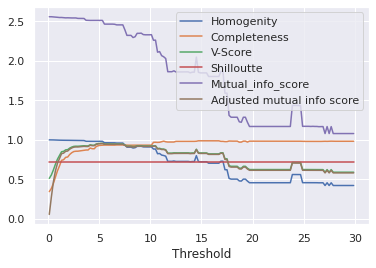

Highest V-cscore : 5.300000000000001


In [47]:
import matplotlib.pyplot as plt 

homogenity = []
completeness = []
vScore = []
shilloutte = []
f_score = []
mutualinfoscore =[]
adjustedmutualinfoscore = []

y = list(cluster_results.keys())
print("Threshold : ", list(y))
for val in cluster_results.items():
  homogenity+=[val[1][0]]
  completeness+=[val[1][1]]
  vScore+=[val[1][2]]
  shilloutte+=[val[1][3]]
  # f_score+=[val[1][4]]
  mutualinfoscore+=[val[1][4]]
  adjustedmutualinfoscore+=[val[1][5]]

# print("F1 Score : ", f_score)
print("Homogenity : ", homogenity)
print("Completeness : ", completeness)
print("V-Score : ", vScore)
print("Shilloutte", shilloutte)
print("Mutual info score", mutualinfoscore)
print("Adjusted mutual info score", adjustedmutualinfoscore)

# plt.plot(y,f_score, label = "F1 Score")
plt.plot(y,homogenity, label = "Homogenity")
plt.plot( y,completeness, label = "Completeness")
plt.plot( y,vScore, label = "V-Score")
plt.plot(y,shilloutte, label = "Shilloutte")
plt.plot(y,mutualinfoscore, label = "Mutual_info_score")
plt.plot(y,adjustedmutualinfoscore, label = "Adjusted mutual info score")

plt.xlabel('Threshold') 

plt.legend()

plt.show() 
print("Highest V-cscore :", y[vScore.index(max(vScore))])

# Write Clustering Results

In [0]:
clustering_Results = {
        'Threshold': y,
        'Homogenity': homogenity,
        'Completeness': completeness,
        'vScore': vScore,
        'Shilloutte': shilloutte,
        'Mutual info score': mutualinfoscore,
        'Adjusted mutual info score': adjustedmutualinfoscore
    }

results = pd.DataFrame(clustering_Results)

results.to_csv(result_dir + '/clustering_results.csv')

# Get template

In [0]:
def getTemplate(candidate):
    # candidate: list of list
    abstraction = ''

    # transpose row to column
    candidate_transpose = list(zip(*candidate))
    candidate_length = len(candidate)

    if candidate_length > 1:
        # get abstraction
        abstraction_list = []
        for index, message in enumerate(candidate_transpose):
            message_length = len(set(message))
            if message_length == 1:
                abstraction_list.append(message[0])
            else:
                abstraction_list.append('<*>')

        abstraction = ' '.join(abstraction_list)

    elif candidate_length == 1:
        abstraction = ' '.join(candidate[0])

    return abstraction

# Read Ground ruth templates

In [0]:
import pandas as pd
df_raw_logs = pd.read_csv("/content/drive/My Drive/" + "Vue4Logs" + "/Datasets_TB/ground_truth/"+ dataset + "/" + dataset +"_2k.log_structured.csv") 
raw_logs = df_raw_logs['Content'].to_numpy()

In [51]:
raw_logs

array(['Notification time out: 3200',
       'Received connection request /10.10.34.11:45307',
       'Send worker leaving thread', ...,
       'Expiring session 0x14f05578bd80006, timeout of 10000ms exceeded',
       'Expiring session 0x14f05578bd8000f, timeout of 10000ms exceeded',
       'Processed session termination for sessionid: 0x24f0557806a0010'],
      dtype=object)

# Get best clusterong based config

In [52]:
len(raw_logs)

2000

In [53]:
predicted_labels = predicted_labels[y[vScore.index(max(vScore))]]
predicted_labels

array([ 0,  1,  2, ..., 38, 38, 37])

In [54]:
groups = pd.DataFrame()
groups['predicted_labels'] = predicted_labels
groups['raw_logs'] = raw_logs
groups

,predicted_labels,raw_logs
0,0,Notification time out: 3200
1,1,Received connection request /10.10.34.11:45307
2,2,Send worker leaving thread
3,3,Interrupted while waiting for message on queue
4,2,Send worker leaving thread
...,...,...
1995,8,Client attempting to establish new session at ...
1996,7,Closed socket connection for client /10.10.34....
1997,38,"Expiring session 0x14f05578bd80006, timeout of..."
1998,38,"Expiring session 0x14f05578bd8000f, timeout of..."


In [55]:
for i in np.unique(groups.predicted_labels):
  print(i)
  for index,row in groups.iterrows():
    if row['predicted_labels'] == i:
      print(row['raw_logs'])
  print('\n')


0
Notification time out: 3200
Notification time out: 60000
Notification time out: 60000
Notification time out: 60000
Notification time out: 60000
Notification time out: 60000
Notification time out: 60000
Notification time out: 60000
Notification time out: 60000
Notification time out: 60000
Notification time out: 60000
Notification time out: 60000
Notification time out: 60000
Notification time out: 60000
Notification time out: 60000
Notification time out: 60000
Notification time out: 60000
Notification time out: 60000
Notification time out: 60000
Notification time out: 60000
Notification time out: 60000
Notification time out: 60000
Notification time out: 60000
Notification time out: 60000
Notification time out: 60000
Notification time out: 60000
Notification time out: 60000
Notification time out: 60000
Notification time out: 60000
Notification time out: 60000
Notification time out: 60000
Notification time out: 60000
Notification time out: 60000
Notification time out: 60000
Notification 

In [56]:
clusters = {}
for i in range(0, len(predicted_labels)):
    try:
        clusters[predicted_labels[i]].append(raw_logs[i].split(" "))
    except KeyError:
        clusters[predicted_labels[i]] = [raw_logs[i].split(" ")]


output = {}
for cluster in clusters.items():
  template = getTemplate(cluster[1])
  output['E' + str(cluster[0])] = template
  print(template)
  for log in cluster[1]:
    print(log)
  print('\n')


def writeOutput(output):
    line = {
        'EventId': list(output.keys()),
        'EventTemplate': list(output.values())
    }

    df = pd.DataFrame(line)
    df.to_csv((result_dir + 'templates.csv'))
  
  
writeOutput(output)

Notification time out: <*>
['Notification', 'time', 'out:', '3200']
['Notification', 'time', 'out:', '60000']
['Notification', 'time', 'out:', '60000']
['Notification', 'time', 'out:', '60000']
['Notification', 'time', 'out:', '60000']
['Notification', 'time', 'out:', '60000']
['Notification', 'time', 'out:', '60000']
['Notification', 'time', 'out:', '60000']
['Notification', 'time', 'out:', '60000']
['Notification', 'time', 'out:', '60000']
['Notification', 'time', 'out:', '60000']
['Notification', 'time', 'out:', '60000']
['Notification', 'time', 'out:', '60000']
['Notification', 'time', 'out:', '60000']
['Notification', 'time', 'out:', '60000']
['Notification', 'time', 'out:', '60000']
['Notification', 'time', 'out:', '60000']
['Notification', 'time', 'out:', '60000']
['Notification', 'time', 'out:', '60000']
['Notification', 'time', 'out:', '60000']
['Notification', 'time', 'out:', '60000']
['Notification', 'time', 'out:', '60000']
['Notification', 'time', 'out:', '60000']
['Notifi

In [0]:
structured_log = df_raw_logs.drop(['EventTemplate','EventId'], axis=1)
df_eventTemplates = pd.read_csv(result_dir + 'templates.csv')

In [0]:
template = []
eventId = []
 
for label in predicted_labels:
  template.append(df_eventTemplates[df_eventTemplates['EventId'] == 'E'+str(label)]['EventTemplate']) 
  eventId.append(df_eventTemplates[df_eventTemplates['EventId'] == 'E'+str(label)]['EventId'])

In [0]:
structured_log['EventId'] = eventId
structured_log['EventTemplate'] = template

In [0]:
structured_log.to_csv(result_dir + 'structured.csv')

In [0]:
def evaluate(groundtruth, parsedresult):
    
    df_groundtruth = pd.read_csv(groundtruth)
    df_parsedlog = pd.read_csv(parsedresult)

    # Remove invalid groundtruth event Templates
    null_logids = df_groundtruth[~df_groundtruth['EventTemplate'].isnull()].index
    df_groundtruth = df_groundtruth.loc[null_logids]
    df_parsedlog = df_parsedlog.loc[null_logids]

    (precision, recall, f_measure, accuracy) = get_accuracy(df_groundtruth['EventTemplate'], df_parsedlog['EventTemplate'])
    print('Precision: %.4f, Recall: %.4f, F1_measure: %.4f, Parsing_Accuracy: %.4f' % (
        precision, recall, f_measure, accuracy))
    return f_measure, accuracy


def get_accuracy(series_groundtruth, series_parsedlog, debug=False):
   
    series_groundtruth_valuecounts = series_groundtruth.value_counts()
    real_pairs = 0
    for count in series_groundtruth_valuecounts:
        if count > 1:
            real_pairs += scipy.special.comb(count, 2)

    series_parsedlog_valuecounts = series_parsedlog.value_counts()
    parsed_pairs = 0
    for count in series_parsedlog_valuecounts:
        if count > 1:
            parsed_pairs += scipy.special.comb(count, 2)

    accurate_pairs = 0
    accurate_events = 0  # determine how many lines are correctly parsed
    for parsed_eventId in series_parsedlog_valuecounts.index:
        logIds = series_parsedlog[series_parsedlog == parsed_eventId].index
        series_groundtruth_logId_valuecounts = series_groundtruth[logIds].value_counts()
        error_eventIds = (parsed_eventId, series_groundtruth_logId_valuecounts.index.tolist())
        error = True
        if series_groundtruth_logId_valuecounts.size == 1:
            groundtruth_eventId = series_groundtruth_logId_valuecounts.index[0]
            if logIds.size == series_groundtruth[series_groundtruth == groundtruth_eventId].size:
                accurate_events += logIds.size
                error = False
        if error and debug:
            print('(parsed_eventId, groundtruth_eventId) =', error_eventIds, 'failed', logIds.size, 'messages')
        for count in series_groundtruth_logId_valuecounts:
            if count > 1:
                accurate_pairs += scipy.special.comb(count, 2)

    precision = float(accurate_pairs) / parsed_pairs
    recall = float(accurate_pairs) / real_pairs
    f_measure = 2 * precision * recall / (precision + recall)
    accuracy = float(accurate_events) / series_groundtruth.size
    return precision, recall, f_measure, accuracy


In [62]:
print(evaluate("/content/drive/My Drive/Vue4Logs/Datasets_TB/ground_truth/"+ dataset + "/" + dataset +"_2k.log_structured.csv",    #####path of the structured log csv of the groundtruth
               result_dir+ 'structured.csv'))

Precision: 0.9858, Recall: 0.8944, F1_measure: 0.9379, Parsing_Accuracy: 0.5730
(0.9379059821844223, 0.573)


In [65]:
cd ..

/content/drive/My Drive/Vue4Logs


In [66]:
!cp -r Thaler2017/results/{dataset_number}_{dataset} /content/gdrive/My\ Drive/{project_directory}/our_experiments/{experiment_type}/{dataset}

cp: cannot stat 'Thaler2017/results/{dataset_number}_{dataset}': No such file or directory
